In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import torch

%run "/code/source/notebooks/notebook_settings.py"
import source.config.config as config
import helpsk as hlp
import os
import pandas as pd

In [5]:
with hlp.utility.Timer("Loading Data"):
    file_path = os.path.join(config.dir_data_raw(), 'auto_mpg.pkl')
    auto_mpg = pd.pandas.read_pickle(file_path)

Timer Started: Loading Data
Timer Finished (0.01 seconds)


In [6]:
hlp.pandas.numeric_summary(auto_mpg)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
MPG,398,0,0.0%,0,0.0%,23.5,7.8,0.3,0.5,-0.5,9.0,14.0,17.5,23.0,29.0,34.3,46.6
Cylinders,398,0,0.0%,0,0.0%,5.5,1.7,0.3,0.5,-1.4,3.0,4.0,4.0,4.0,8.0,8.0,8.0
Displacement,398,0,0.0%,0,0.0%,193.4,104.3,0.5,0.7,-0.8,68.0,90.0,104.2,148.5,262.0,350.0,455.0
Horsepower,392,6,2.0%,0,0.0%,104.5,38.5,0.4,1.1,0.7,46.0,67.0,75.0,93.5,126.0,157.7,230.0
Weight,398,0,0.0%,0,0.0%,"2,970.4",846.8,0.3,0.5,-0.8,"1,613.0","1,988.5","2,223.8","2,803.5","3,608.0","4,275.2","5,140.0"
Acceleration,398,0,0.0%,0,0.0%,15.6,2.8,0.2,0.3,0.4,8.0,12.0,13.8,15.5,17.2,19.0,24.8
Model Year,398,0,0.0%,0,0.0%,76.0,3.7,0.1,0.0,-1.2,70.0,71.0,73.0,76.0,79.0,81.0,82.0
Origin,398,0,0.0%,0,0.0%,1.6,0.8,0.5,0.9,-0.8,1.0,1.0,1.0,1.0,2.0,3.0,3.0


In [7]:
auto_mpg.dropna(inplace=True)
assert auto_mpg.isna().sum().sum() == 0

In [9]:
y_all = auto_mpg['MPG'].values
X_all = auto_mpg.drop(columns='MPG')

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, train_size=0.8, random_state=1
)
assert len(X_train) + len(X_test) == len(X_all)
assert len(y_train) + len(y_test) == len(y_all)
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [10]:
numeric_column_names = [
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
]
non_numeric_column_names = [
    'Cylinders',
    'Origin'
]

numeric_pipeline = make_pipeline(StandardScaler())
non_numeric_pipeline = make_pipeline(OneHotEncoder())

def to_tensor(x):
    return torch.from_numpy(x).float()

pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_column_names),
        ('non_numeric', non_numeric_pipeline, non_numeric_column_names)
    ]),
    FunctionTransformer(func=to_tensor),
)

n_train = len(X_train)
n_test = len(X_test)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
assert n_train == len(X_train)
assert n_test == len(X_test)

y_train = to_tensor(y_train)
y_test = to_tensor(y_test)

In [12]:
import torch.nn as nn
from source.domain.pytorch_wrappers import FullyConnectedNN

network = FullyConnectedNN(
    input_size=X_train.shape[1],
    output_size=1,
    hidden_units=[8, 4],
    loss_func=nn.MSELoss(),
    learning_rate=0.001
)

loss_hist_train, loss_hist_validation = network.train(
    X=X_train,
    y=y_train,
    batch_size=8,
    random_seed=2
)

2022-11-30 02:00:09 - INFO     | Validation loss decreased (inf --> nan). Saving model ...
2022-11-30 02:00:09 - INFO     | Validation loss decreased (nan --> 539.931274). Saving model ...
2022-11-30 02:00:09 - INFO     | Validation loss decreased (539.931274 --> 23.897884). Saving model ...
2022-11-30 02:00:09 - INFO     | Validation loss decreased (23.897884 --> 12.364902). Saving model ...
2022-11-30 02:00:09 - INFO     | Validation loss decreased (12.364902 --> 8.614422). Saving model ...
2022-11-30 02:00:09 - INFO     | Early Stopping counter: 1 out of 10
2022-11-30 02:00:09 - INFO     | Validation loss decreased (8.614422 --> 7.076130). Saving model ...
2022-11-30 02:00:09 - INFO     | Validation loss decreased (7.076130 --> 7.072500). Saving model ...
2022-11-30 02:00:09 - INFO     | Validation loss decreased (7.072500 --> 7.039890). Saving model ...
2022-11-30 02:00:09 - INFO     | Early Stopping counter: 1 out of 10
2022-11-30 02:00:09 - INFO     | Early Stopping counter: 2 ou

In [14]:
network._early_stopping._index

38

In [13]:
test_pred = network.predict(X=X_test)
mse = nn.MSELoss()(test_pred, y_test).item()
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {nn.L1Loss()(test_pred, y_test).item():.4f}')

Test MSE: 11.2759
Test MAE: 2.2533


Text(0.5, 0, 'Epochs')

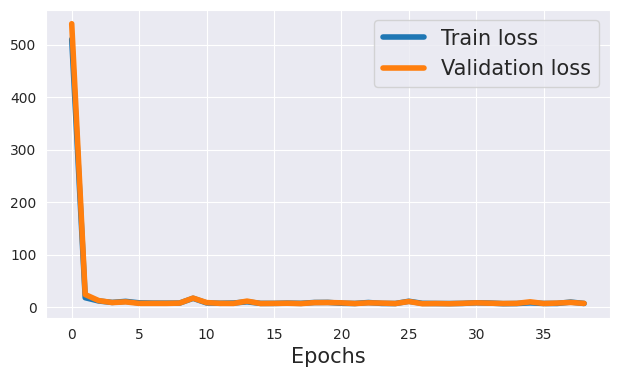

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_validation, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)


---